# CNN Development

## Structure

We will have 4 separated convolutional networks, three for the 2D features and another to the 1D data, that will be flattened and concatenated into a MLP

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.python.client import device_lib
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pickle

### Model

Features & Shapes:

- 2D Chromagram: (12, 321)
- 2D Mel Spectogram: (128, 321)
- 2D Fourier Tempogram: (508, 322)
- 1D Features: (40)

#### Chromagram Layer

In [ ]:
chromagram_shape = (12, 321, 1)

chromagram_input = keras.Input(shape=chromagram_shape, name='chromagram_input')

chromalayer = layers.Conv2D(64, (4,4), activation='relu')(chromagram_input)
# chromalayer = layers.Conv2D(64, (3,3), activation='relu')(chromalayer)
chromalayer = layers.MaxPooling2D((2,2))(chromalayer)
chromalayer = layers.Dropout(0.2)(chromalayer)
# chromalayer = layers.Conv2D(64, (3,3), activation='relu')(chromalayer)
chromalayer = layers.Flatten()(chromalayer)

#### Mel Spectrogram Layer

In [ ]:
mel_shape = (128, 321, 1)

mel_spectogram_input = keras.Input(shape=mel_shape, name='mel_spectogram_input')

mellayer = layers.Conv2D(64, (3,3), activation='relu')(mel_spectogram_input)
mellayer = layers.MaxPooling2D((2,2))(mellayer)
mellayer = layers.Dropout(0.3)(mellayer)
mellayer = layers.Conv2D(32, (3,3), activation='relu')(mellayer)
mellayer = layers.MaxPooling2D((2,2))(mellayer)
mellayer = layers.Dropout(0.3)(mellayer)
mellayer = layers.Flatten()(mellayer)

#### Fourier Tempogram Layer

In [ ]:
tempogram_shape = (508, 322, 1)

fourier_tempogram = keras.Input(shape=tempogram_shape, name='fourier_tempogram')

fourierlayer = layers.Conv2D(128, (3,3), activation='relu')(fourier_tempogram)
fourierlayer = layers.MaxPooling2D((3,3))(fourierlayer)
fourierlayer = layers.Conv2D(64, (3,3), activation='relu')(fourierlayer)
fourierlayer = layers.MaxPooling2D((3,3))(fourierlayer)	
fourierlayer = layers.Dropout(0.3)(fourierlayer)
fourierlayer = layers.Conv2D(32, (3,3), activation='relu')(fourierlayer)
# fourierlayer = layers.Dropout(0.4)(fourierlayer)
# fourierlayer = layers.Conv2D(64, (3,3), activation='relu')(fourierlayer)
fourierlayer = layers.Flatten()(fourierlayer)

#### 1D Features Layer

In [ ]:
features_1d_shape = (321, 4)

features_1d = keras.Input(shape=features_1d_shape, name='features_1d')

featureslayer = layers.Conv1D(32, 3, activation='relu')(features_1d)
featureslayer = layers.MaxPooling1D(2)(featureslayer)
featureslayer = layers.Conv1D(64, 3, activation='relu')(featureslayer)
featureslayer = layers.MaxPooling1D(2)(featureslayer)
featureslayer = layers.Dropout(0.2)(featureslayer)
featureslayer = layers.Conv1D(64, 3, activation='relu')(featureslayer)
featureslayer = layers.Flatten()(featureslayer)


#### Combined Layers

In [ ]:
combined = layers.concatenate([fourierlayer, mellayer, featureslayer])
combined = layers.Dense(128, activation='relu')(combined)
combined = layers.Dropout(0.2)(combined)
combined = layers.Dense(64, activation='relu')(combined)
combined = layers.Dropout(0.2)(combined)
combined = layers.Dense(32, activation='relu')(combined)
combined = layers.Dropout(0.2)(combined)
combined = layers.Dense(10, activation='softmax')(combined)

model = keras.Model(inputs=[mel_spectogram_input, fourier_tempogram, features_1d], outputs=combined)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fourier_tempogram (InputLa  [(None, 508, 322, 1)]        0         []                            
 yer)                                                                                             
                                                                                                  
 mel_spectogram_input (Inpu  [(None, 128, 321, 1)]        0         []                            
 tLayer)                                                                                          
                                                                                                  
 features_1d (InputLayer)    [(None, 321, 4)]             0         []                            
                                                                                              

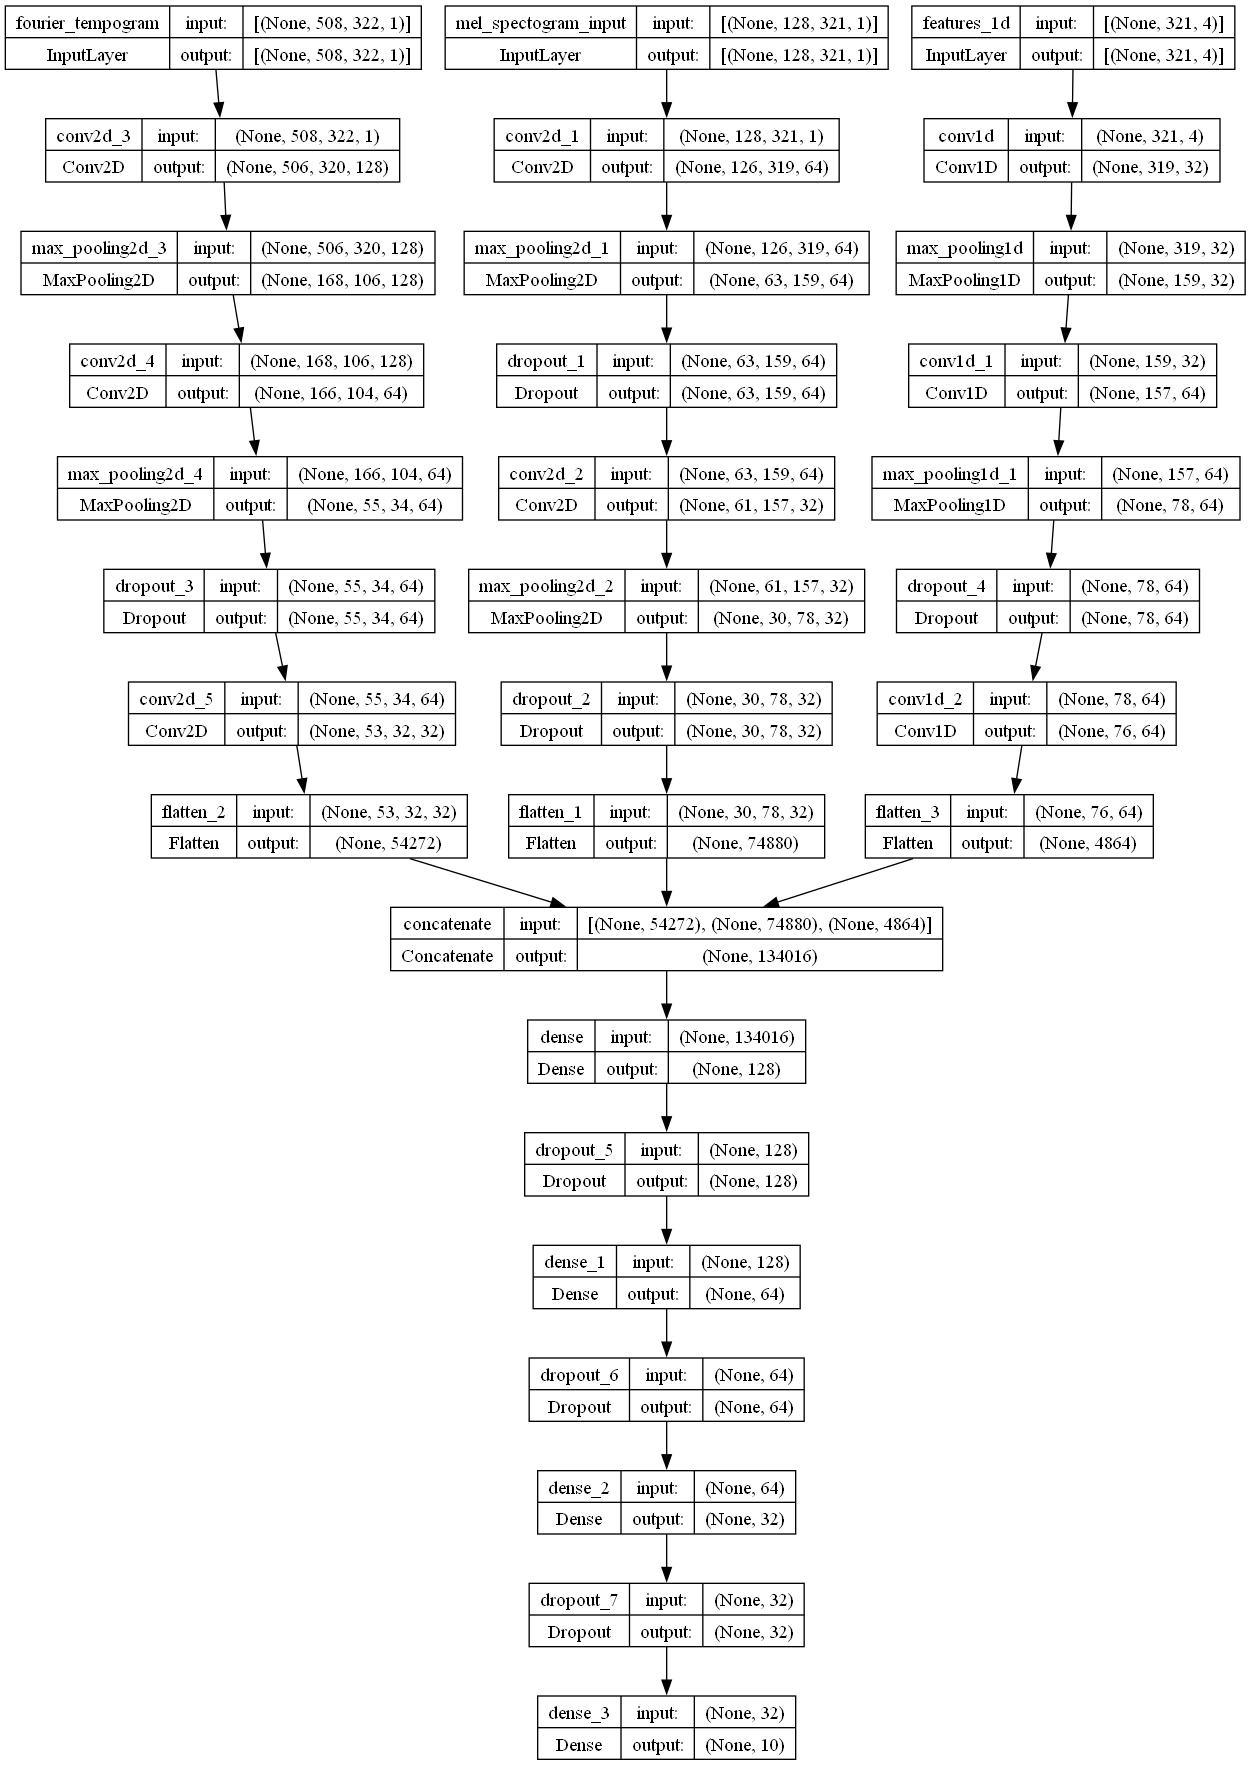

In [ ]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

### Importing the Data

In [ ]:
import pickle

def load_pkl(path):
    to_return = None
    with open(path, "rb") as loaded_data:
        to_return = pickle.load(loaded_data)
    loaded_data.close()
    return to_return


## Training the Model in a 10 Fold Cross-Validation

In [ ]:
def reshape_data(traindata):
    # train_chroma = np.asarray(tuple(traindata["chromagram"].to_list())).astype(np.float32)
    train_mel = np.asarray(tuple(traindata["mel_spectogram"].to_list())).astype(np.float32)
    train_fourier = np.asarray(tuple(traindata["fourier_tempogram"].to_list())).astype(np.float32)
    
    a = np.asarray(tuple(traindata["spectral_centroid"].to_list())).astype(np.float32)
    b = np.asarray(tuple(traindata["spectral_bandwidth"].to_list())).astype(np.float32)
    c = np.asarray(tuple(traindata["spectral_flatness"].to_list())).astype(np.float32)
    d = np.asarray(tuple(traindata["spectral_rolloff"].to_list())).astype(np.float32)

    train_1d = np.stack([a,b,c,d], axis=-1)
    print(train_1d.shape)
    train_1d = train_1d.reshape(-1, 321, 4)

    # train_chroma = np.array([np.array(val) for val in train_chroma])
    train_mel = np.array([np.array(val) for val in train_mel])
    train_fourier = np.array([np.array(val) for val in train_fourier])

    return train_mel, train_fourier, train_1d

In [ ]:
def train_val_test_split(test_fold):
    test_df = load_pkl(f"assets/fold{test_fold}_df.pkl")
    test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)
    train_df = pd.DataFrame(columns=test_df.columns)
    print(test_df.columns)
    print(train_df.columns)
    print(val_df.columns)
    for i in range(1, 10+1):
        if i == test_fold: continue
        fold_df = load_pkl(f"assets/fold{i}_df.pkl")
        train_df = pd.concat([train_df, fold_df], axis=0, join='outer', ignore_index=True)
        del fold_df
    X_train, y_train = train_df.drop(columns=['slice_file_name','classID']), train_df['classID']
    X_val, y_val = val_df.drop(columns=['slice_file_name','classID']), val_df['classID']
    X_test, y_test = test_df.drop(columns=['slice_file_name','classID']), test_df['classID']
    del test_df
    del train_df
    del val_df
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(5) 

y_val = np.asarray(y_val.to_list()).astype(np.float32)
y_train = np.asarray(y_train.to_list()).astype(np.float32)
y_test = np.asarray(y_test.to_list()).astype(np.float32)

Index(['slice_file_name', 'chromagram', 'mel_spectogram', 'fourier_tempogram',
       'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness',
       'spectral_rolloff', 'classID'],
      dtype='object')
Index(['slice_file_name', 'chromagram', 'mel_spectogram', 'fourier_tempogram',
       'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness',
       'spectral_rolloff', 'classID'],
      dtype='object')
Index(['slice_file_name', 'chromagram', 'mel_spectogram', 'fourier_tempogram',
       'spectral_centroid', 'spectral_bandwidth', 'spectral_flatness',
       'spectral_rolloff', 'classID'],
      dtype='object')


In [ ]:
X_train_mel, X_train_fourier, X_train_1d = reshape_data(X_train)
X_val_mel, X_val_fourier, X_val_1d = reshape_data(X_val)
X_test_mel, X_test_fourier, X_test_1d = reshape_data(X_test)

(7796, 1, 321, 4)
(468, 1, 321, 4)
(468, 1, 321, 4)


### Due to memory constraints, I present to thee: Keras Generators

In [ ]:
from tensorflow.keras.utils import Sequence
batch_sizegen = 50

class DataGenerator(Sequence):
    def __init__(self, X_1d, X_mel, X_fourier, y, batch_size):
        self.X_1d = X_1d
        self.X_mel = X_mel
        self.X_fourier = X_fourier
        self.y = y
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.X_1d))

    def __len__(self):
        return int(np.ceil(len(self.X_1d) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size

        batch_X_1d = self.X_1d[start:end]
        batch_X_mel = self.X_mel[start:end]
        batch_X_fourier = self.X_fourier[start:end]
        batch_y = self.y[start:end]

        return {'features_1d': batch_X_1d, 'mel_spectogram_input': batch_X_mel, 'fourier_tempogram': batch_X_fourier}, batch_y

train_generator = DataGenerator(X_train_1d, X_train_mel, X_train_fourier, y_train, batch_sizegen)
val_generator = DataGenerator(X_val_1d, X_val_mel, X_val_fourier, y_val, batch_sizegen)

## Model Compilation and Training

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

a = model.fit(train_generator,
    validation_data=val_generator,
    epochs=25
    )

Epoch 1/25
 2/78 [..............................] - ETA: 1:25:09 - loss: 2.2681 - accuracy: 0.1250

## Model Analysis

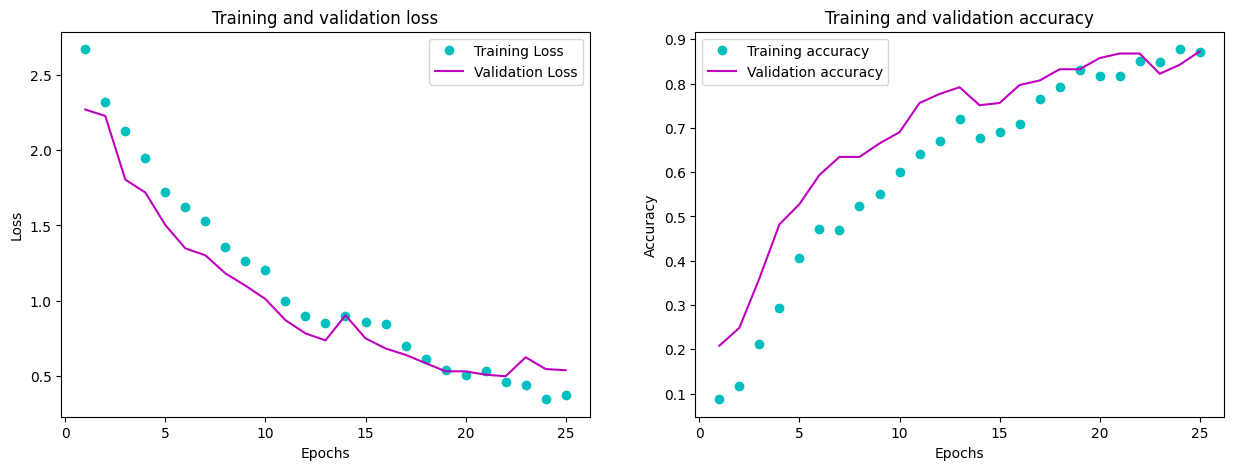

In [ ]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
import matplotlib.pyplot as plt

history_dict = a.history

loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values = history_dict['val_accuracy']

epochs = range(1,26)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()